In [ ]:
 # 残差网络的核心思想是：每个附加层都应该更容易地包含原始函数作为其元素之一。
 #  于是，残差块（residual blocks）便诞生了，这个设计对如何建立深层神经网络产生了深远的影响。
 #  凭借它，ResNet赢得了2015年ImageNet大规模视觉识别挑战赛。

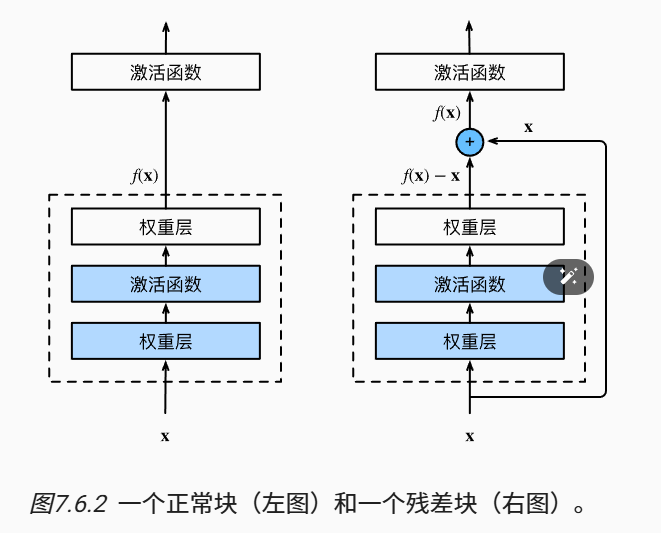

In [1]:
# ResNet沿用了VGG完整的3*3卷积层设计。
# 残差块里首先有2个有相同输出通道的3 * 3卷积层
# 每个卷积层后接一个批量规范化层和ReLU激活函数
# 然后我们通过跨层数据通路，跳过这2个卷积运算，将输入直接加在最后的ReLU激活函数前
# 这要求：2个卷积层的输出和输入形状一样
# 如果想改变通道数，就需要引入一个额外的1 * 1卷积层

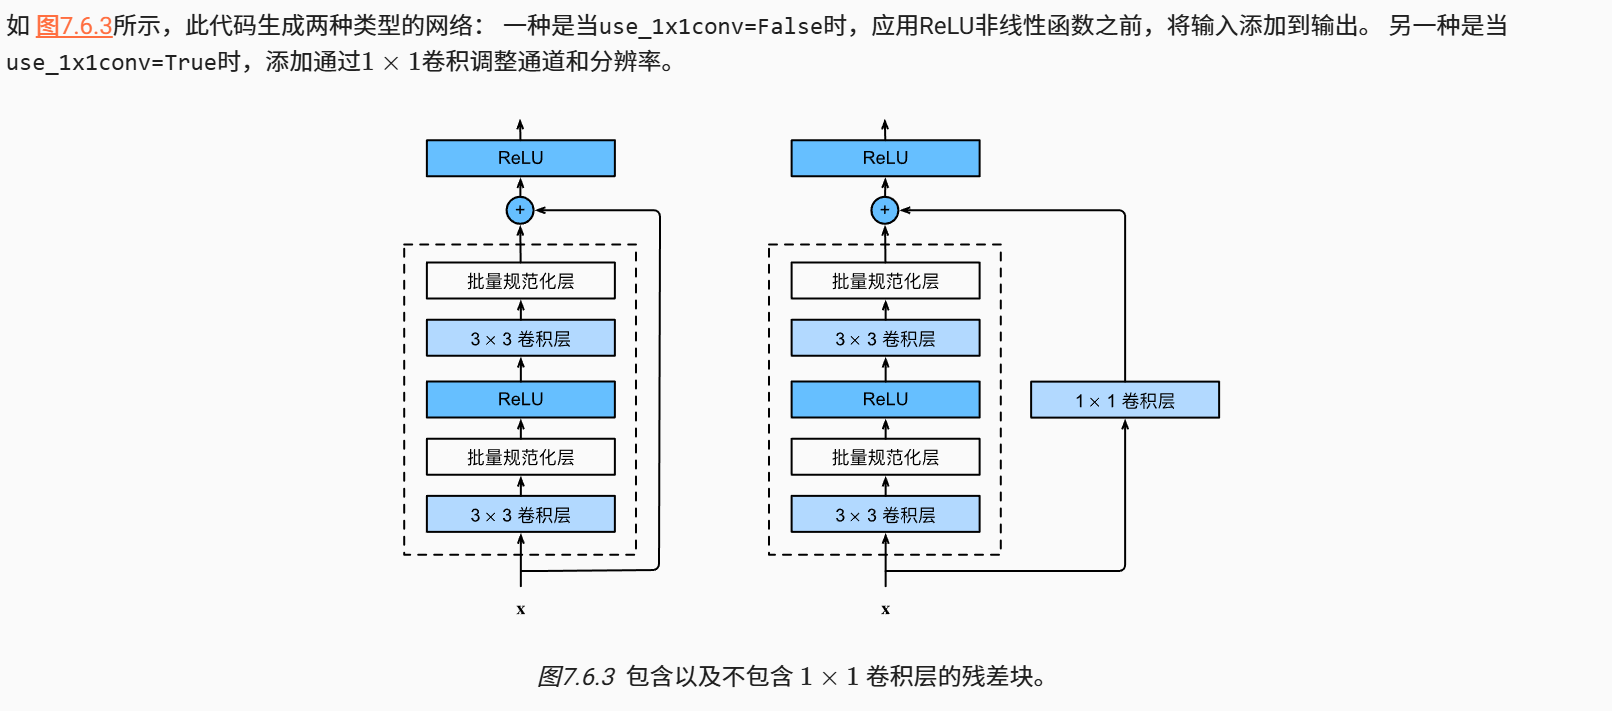

In [9]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

class Residual(nn.Module):
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, 
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, 
                               kernel_size=3, padding=1)
        if use_1x1conv:  # 调整通道和分辨率
            self.conv3 = nn.Conv2d(input_channels, num_channels, 
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
    
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [10]:
# 查看输入和输出形状一致的情况
blk = Residual(3, 3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [11]:
# 我们可以在增加输出通道数的同时，减半输出的高和宽
blk = Residual(3, 6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

In [12]:
# ResNet模型
# 前两层和GoogLeNet一样，不同之处在于ResNet的每个卷积层后增加了批量规范化层
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [13]:
# GoogLeNet在后面接了4个由inception块组成的模块；ResNet则使用4个残差块组成的模块
# 第一个模块的通道数同输入通道数一致。 由于之前已经使用了步幅为2的最大汇聚层，所以无须减小高和宽。
# 之后的每个模块在第一个残差块里将上一个模块的通道数翻倍，并将高和宽减半。

In [15]:
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [16]:
# 在ResNet加入所有残差块，这里每个模块使用2个残差块
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [17]:
# 与GoogLeNet一样，在ResNet中加入全局平均汇聚层，以及全连接层输出
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),  # 将每个通道的宽和变成1
                    nn.Flatten(), nn.Linear(512, 10))

In [18]:
# 每个模块有4个卷积层（不包括恒等映射的1*1卷积层）， 加上第一个7 * 7卷积层和最后一个全连接层
# 总共18层。所以通常被乘坐ResNet-18
# 通过配置不同的通道数和模块里的残差块数可以得到不同的ResNet模型
# 例如更深的含152层的ResNet-152
# 虽然ResNet的主体架构跟GoogLeNet类似，但ResNet架构更简单，修改也更方便。这些因素都导致了ResNet迅速被广泛使用。 图7.6.4描述了完整的ResNet-18。

完整的ResNet模型
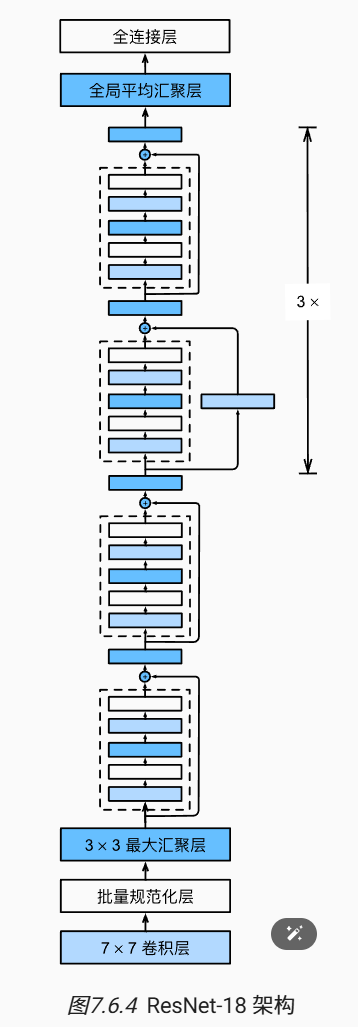

In [19]:
# 观察不同模块的输入形状是如何变化的
# 在之前所有架构中，分辨率降低，通道数量增加，直到全局平均汇聚层聚集所有特征。
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


loss 0.118, train acc 0.955, test acc 0.836
15276.7 examples/sec on cuda:0


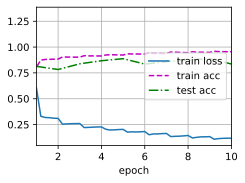

In [20]:
# 训练模型
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())